# Analysis ver2

This is a derived and cleaned up version of Analysis_ver1, with better pipelines for the data.  Inadvertently deleted some cells when renaming.

In [1]:
%matplotlib inline

In [2]:
cd /home/tobiszuts/data/insight/project

[Errno 2] No such file or directory: '/home/tobiszuts/data/insight/project'
/media/tobiszuts/Windows/Data/Work/Insight/project


# Data cleaning

Get the data and start processing.

In [3]:
import pickle
file_save = "Reddit_depression.p"
results = pickle.load( open(file_save, 'rb'))

## Feature engineering and exploring!

Start with looking at authors: how many unique ones?  How many posts did each write?

In [4]:
data.describe()

NameError: name 'data' is not defined

In [ ]:
len(data.author.unique())

In [ ]:
len(data)

In [ ]:
import matplotlib.pyplot as plt

print(data.author.value_counts()[:3])

fig, axes = plt.subplots(1, 2, figsize = (10,4))
data.author.value_counts()[1:].hist(ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('Number of Posts per User')
axes[0].set_ylabel('Count')

data.author.value_counts()[1:].hist(ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Number of Posts per User')


This is a power law, as expected.

In [ ]:
dates = pd.to_datetime(data.created_utc, unit="s")
data.created = dates
dates.describe()

In [ ]:
plt.subplots(1,1, figsize = (6,4))
data.created.hist(bins=126)  # two bins per month
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Num Posts')

In [ ]:
sum(data.created.dt.year<2011)/len(data)

That is, only 3% of the posts are from 2009 or 2010.  Probably best to filter these out, since the community is still growing quickkly and might have very different characteristics than later on.

In [ ]:
dates.dt.dayofweek.hist(bins=7)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))

data.ups.hist(ax = axes[0], bins=50)
axes[0].set_yscale('log')
axes[0].set_xlabel('number of ups')
axes[0].set_ylabel('Count')
plt.yscale('log')

data.downs.hist(ax = axes[1], bins=50)
axes[1].set_yscale('log')
axes[1].set_xlabel('number of downs')
#axes[1].set_xlim([0, 2000])

data.score.hist(ax = axes[2], bins=50)
axes[2].set_yscale('log')
axes[2].set_xlabel('number of scores')


In [ ]:
data.num_comments.hist(bins=100, figsize=(6,4))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Count')
plt.xlabel('Number of Comments')

In [ ]:
print('Number of commentless posts = {}\nNumber of posts with 7+ comments = {}'.format(
    len(data[data.num_comments==0]), len(data[data.num_comments>=7])))

In [ ]:
dates.dt.hour.hist(bins=24, figsize=(6,4))
plt.xlabel('Hour Posted (GMT)')
plt.ylabel('Count')

In [ ]:
data.post_len = data.selftext.apply(lambda x: len(x))
data.post_len.hist(bins=100)
plt.yscale('log')

In [ ]:
print(data.selftext[1])
data.selftext[1].count('?')

In [327]:
def PreProcessData(raw_data, extract_keys) :
    """ This processes the post data, and can be used as 
    a template for the upload data.
    """
    import pandas as pd
    
    data_raw = pd.DataFrame(raw_data)
    data = data_raw[sorted(extract_keys)].copy()
        
    dates = pd.to_datetime(data.created_utc, unit="s")
    data['created_dayofweek'] = dates.dt.dayofweek
    data['created_hour'] = dates.dt.hour
    data['created_month'] = dates.dt.month
    data['created_year'] = dates.dt.year
    data = data[ data.created_year > 2011]
    
    data['post_len'] = data.selftext.apply(lambda x: len(x))
    data['num_qs'] = data.selftext.apply(lambda x: x.count('?'))

    print(pd.to_datetime(data.created_utc.min(), unit="s"))

    # get rid of columns that aren't needed for the model
    drop_cols = ['created_utc', 'author', 'downs', 'ups', 'score', 'id']
    #print(data.head())
        
    return data.drop(drop_cols, axis=1)

extract_keys = ['id', 'author', 'score', 'num_comments', 'downs', 'ups', 
                'created_utc', 'title', 'selftext']
data_clean = PreProcessData(results, extract_keys)
data_clean.head()

2011-01-01 01:00:04


,num_comments,selftext,title,created_dayofweek,created_hour,created_month,created_year,post_len,num_qs
0,0,"I can't think straight, I can't concentrate, I...",I feel like my brain doesn't work anymore.,4,14,2,2014,747,1
1,0,There is this amazing girl that i've known sin...,She's the girl i was always looking for... But...,4,14,2,2014,789,5
2,1,I've been struggling with depression since hig...,I don't have anyone and I don't know why,4,14,2,2014,771,0
3,0,i burn myself..... i heat up a knife and hold ...,how often do you guys inflict self harm?,4,13,2,2014,337,1
4,0,I’m scared\n Of myself\n ...,All I do is hide,4,12,2,2014,671,0


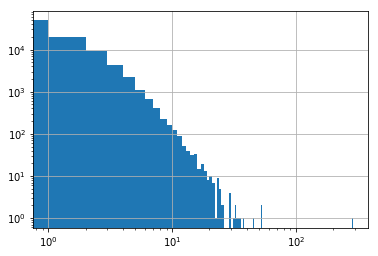

In [66]:
data_clean.num_qs.hist(bins=286)
plt.yscale('log')
plt.xscale('log')

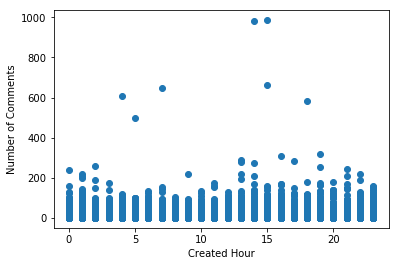

In [43]:
plt.scatter(data_clean.created_hour, data_clean.num_comments)
plt.xlabel('Created Hour')
plt.ylabel('Number of Comments')

# NLP pre-processing

Create the corpus from the text post.

In [74]:
posts = list(data_clean.selftext)

In [73]:
from nltk.tokenize import WordPunctTokenizer
word_punct_tokenizer = WordPunctTokenizer()
word_punct_tokenizer.tokenize("This’s a test.")

['This', '’', 's', 'a', 'test', '.']

In [82]:
posts_tokenized = []
for post in posts :
    words = word_punct_tokenizer.tokenize(post)
    posts_tokenized.append([w.lower() for w in words])
    #print(posts_tokenized[-1][:20])

In [84]:
from gensim import corpora, models, similarities

# dictionary expects a list of tokenized words
post_dictionary = corpora.Dictionary(posts_tokenized)
post_dictionary.save('Posts_dictionary')  # store the dictionary, for future reference
print(post_dictionary)

Dictionary(80188 unique tokens: ['i', 'can', "'", 't', 'think']...)


In [90]:
posts_vec = [post_dictionary.doc2bow(post) for post in posts_tokenized]

In [92]:
print(posts_vec[0])

[(0, 19), (1, 7), (2, 15), (3, 7), (4, 2), (5, 1), (6, 5), (7, 1), (8, 2), (9, 2), (10, 2), (11, 2), (12, 1), (13, 6), (14, 3), (15, 1), (16, 1), (17, 1), (18, 10), (19, 1), (20, 1), (21, 2), (22, 3), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 3), (32, 4), (33, 1), (34, 3), (35, 3), (36, 2), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 3), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 3), (51, 1), (52, 5), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 2), (59, 3), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1)]


Now with this transformation in hand, what are the 10 most informative words in the first post?

In [106]:
tfidf = models.TfidfModel(posts_vec, dictionary=post_dictionary)
tfidf_temp = tfidf[posts_vec[1]]
tfidf_temp.sort(key=lambda x: x[1], reverse=True)
                   
for (x, (key, val)) in enumerate(tfidf_temp[:10]) :
    print('{} {}: {:.3f}'.format(x, post_dictionary[key], val))

0 her: 0.328
1 painful: 0.254
2 smart: 0.227
3 adventurous: 0.225
4 love: 0.213
5 essays: 0.200
6 lover: 0.187
7 handsome: 0.178
8 athletic: 0.177
9 gift: 0.163


In [111]:
posts_words = []
for post in posts_vec :
    tfidf_temp = tfidf[post]
    tfidf_temp.sort(key=lambda x: x[1], reverse=True)
    top_words = []
    for (key, val) in tfidf_temp[:10] :
        #print('{}'.format(post_dictionary[key]), end=', ')
        top_words.append(post_dictionary[key])
    posts_words.append(top_words)

In [124]:
col_labels = ['word_{}'.format(x) for x in range(10)]
data_clean.join(pd.DataFrame(posts_words, columns=col_labels))

,author,created_utc,downs,id,num_comments,score,selftext,title,ups,created,...,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
0,throwaway67640,1.392387e+09,0,1xwb9u,0,1,"I can't think straight, I can't concentrate, I...",I feel like my brain doesn't work anymore.,1,2014-02-14 14:17:07,...,semester,community,iq,brain,college,fails,screwing,verge,damage,dropping
1,Tommy405,1.392387e+09,0,1xwaio,0,1,There is this amazing girl that i've known sin...,She's the girl i was always looking for... But...,1,2014-02-14 14:07:44,...,her,painful,smart,adventurous,love,essays,lover,handsome,athletic,gift
2,periwinkle8,1.392387e+09,0,1xwah3,1,1,I've been struggling with depression since hig...,I don't have anyone and I don't know why,1,2014-02-14 14:07:06,...,hang,sticks,friends,close,girl,friendship,besides,biggest,senior,easily
3,crazy_raconteur,1.392384e+09,0,1xw6ra,0,1,i burn myself..... i heat up a knife and hold ...,how often do you guys inflict self harm?,1,2014-02-14 13:11:44,...,sizzling,.........,conceal,thighs,heat,nine,tunnel,burn,.....,endless
4,ikon106,1.392381e+09,0,1xw4bo,0,1,I’m scared\n Of myself\n ...,All I do is hide,1,2014-02-14 12:28:33,...,hide,’,darkness,healing,fly,numbness,destroying,pain,comforting,feelings
5,ximina3,1.392379e+09,0,1xw2nl,3,1,"I do. \nMy life is almost perfect. I'm 21, and...",Does anyone ever feel selfish?,1,2014-02-14 11:53:59,...,gadgets,nothingness,nice,lovely,passionate,expensive,surrounded,subject,area,studying
6,RequiresCategory,1.392375e+09,0,1xvzuj,3,1,,This day hasn't even started and I'm already c...,1,2014-02-14 10:49:27,...,None,None,None,None,None,None,None,None,None,None
7,dafaddfad,1.392374e+09,0,1xvz8p,1,1,"I'm sitting here, at 5:22 AM before i need to ...",I wish i had some of the things that the peopl...,1,2014-02-14 10:35:17,...,dated,temp,kicked,paycheck,clinicial,bus,car,constants,job,three
8,tallerghostdaniel,1.392373e+09,0,1xvy2u,1,1,Its been fifteen years since I've done this to...,I started cutting myself again and I don't kno...,1,2014-02-14 10:10:13,...,thirty,fifteen,fresh,cuts,arm,man,its,done,almost,old
9,DudeWhatHaveEyes,1.392372e+09,0,1xvxwt,0,1,"Forgive me if this post is written poorly, or ...",Need to try to express my story.,1,2014-02-14 10:06:12,...,ministry,faith,religion,devoted,shattered,church,begin,as,reconnect,deeply


In [188]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
test_sent = 'I haven''t to go up the mountains before coming home'.split(' ') + ['.']
print(test_sent)
results = [stemmer.stem(w) for w in test_sent]
print(results)

['I', 'havent', 'to', 'go', 'up', 'the', 'mountains', 'before', 'coming', 'home', '.']
['i', 'havent', 'to', 'go', 'up', 'the', 'mountain', 'before', 'come', 'home', '.']


In [174]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

See about reducing the number of words by stemming, removing stopwords, and filtering out punctuation.

In [214]:
temp = list(data_clean.selftext[:2])
temp

["I can't think straight, I can't concentrate, I feel like I have brain damage and my IQ is dropping. I forget everything in a second; tell me your name and a minute later it's gone. \n\nI'm in college, and that's a joke; I failed most of my classes last semester, and I'm on the verge of failing the 2 I'm taking this semester. I decided to go to school only half time this semester, and I can't even do that. And it's only community college - who fails community college? I want to drop out. \n\nI can't do this anymore. I can't even have conversations with people anymore because I can't think of anything to say. I've been screwing up at work because I keep missing simple things. I don't know what to do. It's like I can feel my brain wasting away.",
 "There is this amazing girl that i've known since 2012. She was the girl I was looking for. She's very  athletic, smart, beautiful, kind, adventurous, and funny. I love her, i miss her within 10 seconds, and if I do not see her, I feel like my

In [215]:
from nltk.tokenize import WordPunctTokenizer
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
 
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
word_punct_tokenizer = WordPunctTokenizer()
stemmer = SnowballStemmer("english", ignore_stopwords=True)
texts_tokenized = []
for post in temp :
    words = word_punct_tokenizer.tokenize(post)
    words = [w for w in words if (w not in stop_words)]
    texts_tokenized.append([stemmer.stem(w.lower()) for w in words if not all(c in punctuation for c in w)])
print(texts_tokenized)
print([len(text) for text in texts_tokenized])
print([len(word_punct_tokenizer.tokenize(post)) for post in temp])
print(83/191, 94/206)

[['i', 'think', 'straight', 'i', 'concentr', 'i', 'feel', 'like', 'i', 'brain', 'damag', 'iq', 'drop', 'i', 'forget', 'everyth', 'second', 'tell', 'name', 'minut', 'later', 'gone', 'i', 'colleg', 'joke', 'i', 'fail', 'class', 'last', 'semest', 'i', 'verg', 'fail', '2', 'i', 'take', 'semest', 'i', 'decid', 'go', 'school', 'half', 'time', 'semest', 'i', 'even', 'and', 'communiti', 'colleg', 'fail', 'communiti', 'colleg', 'i', 'want', 'drop', 'i', 'anymor', 'i', 'even', 'convers', 'peopl', 'anymor', 'i', 'think', 'anyth', 'say', 'i', 'screw', 'work', 'i', 'keep', 'miss', 'simpl', 'thing', 'i', 'know', 'it', 'like', 'i', 'feel', 'brain', 'wast', 'away'], ['there', 'amaz', 'girl', 'known', 'sinc', '2012', 'she', 'girl', 'i', 'look', 'she', 'athlet', 'smart', 'beauti', 'kind', 'adventur', 'funni', 'i', 'love', 'miss', 'within', '10', 'second', 'i', 'see', 'i', 'feel', 'like', 'whole', 'day', 'wast', 'i', 'tri', 'everyth', 'make', 'love', 'back', 'luck', 'part', 'want', 'get', 'rid', 'alreadi

In [218]:
test = 'can''t'
not all(j in string.punctuation for j in test)

True

That's reduced the number of words in each post by about 55%.

In [219]:
corpus_dictionary = corpora.Dictionary(texts_tokenized)

Bundle this all into one function.

In [290]:
from gensim import corpora, models, similarities

def CreateCorpus(raw_text) :
    """ Create a corpus from an array of documents (each document
        a string).  It expects it as a python object, not a pandas
        one.  Returns an array of tokenized texts and the corpus dictionary.
    """
    from gensim import corpora, models, similarities
    from nltk.tokenize import WordPunctTokenizer
    import string
    from nltk.stem.snowball import SnowballStemmer
    from nltk.corpus import stopwords

    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    word_punct_tokenizer = WordPunctTokenizer()
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    
    texts_proc = []
    for text in raw_text :
        words = word_punct_tokenizer.tokenize(text)
        words = [w for w in words if (w not in stop_words)]
        texts_proc.append([stemmer.stem(w.lower()) for w in words 
                                if not all(c in punctuation for c in w)])
        
    # create dictionary
    corpus_dictionary = corpora.Dictionary(texts_proc)
    corpus_dictionary.filter_extremes(no_below=3, no_above=0.5)
    print(corpus_dictionary)
    
    return texts_proc, corpus_dictionary

In [291]:
# takes ~5 minutes to run
(posts_tokenized, post_dictionary) = CreateCorpus(list(data_clean.selftext))

Dictionary(19924 unique tokens: ['think', 'straight', 'concentr', 'brain', 'damag']...)
Dictionary(19924 unique tokens: ['think', 'straight', 'concentr', 'brain', 'damag']...)


In [305]:
post_dictionary.get(19921)

'jmif'

In [442]:
print(' '.join(posts_tokenized[0]))

i think straight i concentr i feel like i brain damag iq drop i forget everyth second tell name minut later gone i colleg joke i fail class last semest i verg fail 2 i take semest i decid go school half time semest i even and communiti colleg fail communiti colleg i want drop i anymor i even convers peopl anymor i think anyth say i screw work i keep miss simpl thing i know it like i feel brain wast away


Previously (with stop words, no stemming, and extra punctuation), dictionary had 80k terms.  With all that filtering, it now has 20k terms.

This was the previous way to get features, but only returns the top 10 words.  Left here for posterity, but skip ahead to see how to calculate the N most informative words.

In [232]:
def GetTopNWords(texts_tokenized, corpus_dictionary, n) :
    """ For an array of tokenized texts in texts and a dictionary to id mapping,
        create the corpus tf-idf and return the top n words in each text as an array.
    """
    from gensim import corpora, models, similarities
    
    # vectorize the posts
    text_vec = [corpus_dictionary.doc2bow(text) for text in texts_tokenized]

    tfidf = models.TfidfModel(text_vec, dictionary=corpus_dictionary)
    
    text_words = []
    for text in text_vec :
        tfidf_temp = tfidf[text]
        tfidf_temp.sort(key=lambda x: x[1], reverse=True)
        top_words = []
        for (key, val) in tfidf_temp[:n] :
            #print('{}'.format(post_dictionary[key]), end=', ')
            top_words.append(corpus_dictionary[key])
        text_words.append(top_words)
    return text_words, text_vec, tfidf

In [166]:
(top_words, posts_vec, tfidf) = GetTopNWords(posts_tokenized, post_dictionary, 10)

In [170]:
data_clean.head()

,id,num_comments,selftext,title,created_dayofweek,created_hour,created_month,created_year,post_len,num_qs
0,1xwb9u,0,"I can't think straight, I can't concentrate, I...",I feel like my brain doesn't work anymore.,4,14,2,2014,747,1
1,1xwaio,0,There is this amazing girl that i've known sin...,She's the girl i was always looking for... But...,4,14,2,2014,789,5
2,1xwah3,1,I've been struggling with depression since hig...,I don't have anyone and I don't know why,4,14,2,2014,771,0
3,1xw6ra,0,i burn myself..... i heat up a knife and hold ...,how often do you guys inflict self harm?,4,13,2,2014,337,1
4,1xw4bo,0,I’m scared\n Of myself\n ...,All I do is hide,4,12,2,2014,671,0


In [171]:
col_labels = ['word_{}'.format(x) for x in range(10)]
data_clean2 = data_clean.join(pd.DataFrame(top_words, columns=col_labels))

#data_clean.post_len = posts_tokenized

data_clean2.head()

,id,num_comments,selftext,title,created_dayofweek,created_hour,created_month,created_year,post_len,num_qs,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
0,1xwb9u,0,"I can't think straight, I can't concentrate, I...",I feel like my brain doesn't work anymore.,4,14,2,2014,747,1,semester,community,iq,brain,college,fails,screwing,verge,damage,dropping
1,1xwaio,0,There is this amazing girl that i've known sin...,She's the girl i was always looking for... But...,4,14,2,2014,789,5,her,painful,smart,adventurous,love,essays,lover,handsome,athletic,gift
2,1xwah3,1,I've been struggling with depression since hig...,I don't have anyone and I don't know why,4,14,2,2014,771,0,hang,sticks,friends,close,girl,friendship,besides,biggest,senior,easily
3,1xw6ra,0,i burn myself..... i heat up a knife and hold ...,how often do you guys inflict self harm?,4,13,2,2014,337,1,sizzling,.........,conceal,thighs,heat,nine,tunnel,burn,.....,endless
4,1xw4bo,0,I’m scared\n Of myself\n ...,All I do is hide,4,12,2,2014,671,0,hide,’,darkness,healing,fly,numbness,destroying,pain,comforting,feelings


And here's the new method to extract the most important features.

In [306]:
text_vec = [post_dictionary.doc2bow(post) for post in posts_tokenized]
tfidf = models.TfidfModel(text_vec, dictionary=post_dictionary)
print(tfidf)

TfidfModel(num_docs=88060, num_nnz=7512882)


In [307]:
print(text_vec[50001])

[(0, 2), (12, 1), (25, 3), (27, 1), (28, 1), (29, 1), (32, 1), (36, 3), (43, 1), (51, 2), (54, 1), (63, 1), (66, 4), (68, 1), (101, 1), (103, 1), (107, 1), (115, 2), (120, 1), (159, 1), (165, 1), (168, 1), (233, 2), (242, 1), (247, 1), (272, 3), (286, 1), (319, 1), (327, 1), (347, 1), (349, 1), (351, 1), (364, 1), (387, 2), (401, 1), (402, 1), (447, 1), (518, 1), (525, 1), (557, 1), (569, 1), (586, 1), (612, 2), (639, 1), (669, 1), (671, 2), (728, 1), (741, 1), (784, 1), (832, 1), (860, 1), (899, 1), (904, 1), (930, 1), (960, 1), (992, 1), (1004, 1), (1021, 1), (1032, 1), (1109, 1), (1142, 1), (1201, 1), (1276, 1), (1318, 1), (1326, 1), (1342, 1), (1352, 1), (1429, 1), (1467, 1), (1486, 1), (1537, 1), (1590, 1), (1593, 1), (1703, 1), (1782, 1), (1843, 1), (1979, 3), (2369, 2), (2379, 1), (2542, 1), (2678, 1), (2798, 1), (2909, 1), (3080, 1), (3142, 1), (3459, 1), (3664, 1), (3917, 1), (4114, 1), (4145, 1), (4778, 1), (5374, 1), (5548, 1), (6090, 1), (6092, 1), (6772, 1), (7212, 1), (10

In [311]:
tfidf_avg = {}
i = 0
for text in text_vec :
    tfidf_temp = tfidf[text]
    i += 1
    for (key, val) in tfidf_temp :
        #print(key, val)
        if key in tfidf_avg :
            tfidf_avg[key] += val
        else :
            tfidf_avg[key] = val
            
print(len(tfidf_avg))
print(i)
# convert to list and divide by text size
corpus_size = len(text_vec)
tfidf_avg = [(k, v/corpus_size) for k, v in tfidf_avg.items()]
tfidf_avg = sorted(tfidf_avg, key=lambda x: x[1], reverse=True)

19924
88060


In [312]:
for (x, (k, v)) in zip(range(50), tfidf_avg) :
    print('{}  {} ({}): {}'.format(x, post_dictionary[k], k, v))

0  want (32): 0.02155958083645766
1  friend (106): 0.01978423859003115
2  realli (207): 0.01915988140070573
3  go (25): 0.019146203640080958
4  life (168): 0.01836327982854844
5  peopl (35): 0.018148206559327043
6  time (28): 0.018019755446246115
7  year (304): 0.017692990552022506
8  help (97): 0.017649293849342693
9  think (0): 0.017200972161375106
10  thing (43): 0.01688041966858912
11  talk (107): 0.016877828296355906
12  day (66): 0.016650160966660676
13  even (29): 0.016511571672661082
14  would (586): 0.016304766613521253
15  one (101): 0.015879346752897802
16  tri (67): 0.01583992670432827
17  make (68): 0.01567075440085446
18  it (44): 0.015530514644104649
19  work (39): 0.015250175824664683
20  fuck (277): 0.015041982208168866
21  never (158): 0.014639969319726071
22  school (26): 0.014629953462043247
23  start (521): 0.014321242146786727
24  need (94): 0.013963651315903405
25  my (167): 0.013839410962955974
26  much (238): 0.01381069044285206
27  happi (397): 0.0137302745878

In [313]:
tfidf_avg[:5]

[(32, 0.02155958083645766),
 (106, 0.01978423859003115),
 (207, 0.01915988140070573),
 (25, 0.019146203640080958),
 (168, 0.01836327982854844)]

OK, this is now ready for featurizing.

In [315]:
post_dictionary.save(open('Posts_dictionary.p', 'wb'))
print(post_dictionary)

Dictionary(19924 unique tokens: ['think', 'straight', 'concentr', 'brain', 'damag']...)


In [341]:
post_dictionary.load('Posts_dictionary.p')
print(post_dictionary)

Dictionary(100 unique tokens: ['think', 'everyth', 'tell', 'last', 'take']...)


In [319]:
num_words_to_keep = 100
post_dictionary.filter_tokens(good_ids = [word_id for (word_id, tfidf) 
                                          in tfidf_avg[:num_words_to_keep]])
print(post_dictionary)

Dictionary(100 unique tokens: ['think', 'everyth', 'tell', 'last', 'take']...)


Randomly add another feature here, but might actually want the total number of words in the post, which should be about 55% larger.

In [330]:
data_clean.post_len = [len(post) for post in posts_tokenized]

In [349]:
text_vec_short = [post_dictionary.doc2bow(text) for text in posts_tokenized]
tfidf_short = models.TfidfModel(text_vec_short, dictionary=post_dictionary)
print(tfidf_short)

TfidfModel(num_docs=88060, num_nnz=7512882)


In [362]:
len(text_vec_short)

88060

In [370]:
# this takes about 27 s for 10k, 76 s for 20k, 152 s for 30k, 240 s for 40k...call that good for now
import time
start_time = time.time()

baseline = [0 for x in range(num_words_to_keep)]
col_labels = ['word_{}'.format(x) for x in range(num_words_to_keep)]
new_features = pd.DataFrame([], columns=col_labels)
for (x, text) in enumerate(text_vec_short[:40000]) :
    tfidf_temp = tfidf_short[text]
    text_features = baseline.copy()
    for (k, v) in tfidf_temp :
        text_features[k] = v
    
    new_features.loc[x] = text_features
new_features.head()
print("--- %s seconds ---" % (time.time() - start_time))  

--- 237.69495916366577 seconds ---


In [383]:
data_clean2 = data_clean.join(new_features)
data_clean2 = data_clean2[:40000]
data_clean2 = data_clean2.drop(['selftext', 'title'], axis=1)
data_clean2.head()

,num_comments,created_dayofweek,created_hour,created_month,created_year,post_len,num_qs,word_0,word_1,word_2,...,word_90,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99
0,0,4,14,2,2014,83,1,0.269229,0.216921,0.219938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,4,14,2,2014,94,5,0.073880,0.119052,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,4,14,2,2014,80,0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,4,13,2,2014,28,1,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,12,2,2014,77,0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


One example for the week 2 demo.

In [448]:
tfidf_temp = tfidf_short[text_vec_short[0]]
tfidf_temp = sorted(tfidf_temp, key=lambda x: x[1], reverse=True)
for (x, (k,v)) in enumerate(tfidf_temp) :
    print('{} {}: {:.2f}'.format(x, post_dictionary[k], v))

0 anymor: 0.49
1 even: 0.27
2 think: 0.27
3 and: 0.25
4 away: 0.24
5 keep: 0.24
6 tell: 0.22
7 school: 0.22
8 last: 0.22
9 everyth: 0.22
10 say: 0.20
11 take: 0.20
12 anyth: 0.18
13 work: 0.18
14 it: 0.15
15 peopl: 0.15
16 thing: 0.13
17 time: 0.11
18 want: 0.10
19 go: 0.10


# Model

Start with a random forest.

In [416]:
from sklearn import ensemble, linear_model

class BuildModel() :
    
    def __init__(self, data_x, data_y, model_type = 'randomforest', test_frac = 0.2) :
        from sklearn import ensemble, linear_model
        from sklearn.model_selection import train_test_split
        
        (self.train_x, self.test_x, self.train_y, self.test_y) = train_test_split(
                    data_x, data_y, test_size = test_frac)
        print(self.train_x.shape, self.test_x.shape, self.train_y.shape, self.test_y.shape)
        
        if model_type == 'randomforest' :
            self.model = ensemble.RandomForestRegressor()
        elif model_type == 'gradientboostingregressor' :
            self.model = ensemble.GradientBoostingRegressor()
        elif model_type == 'linearregression' :
            self.model = linear_model.LinearRegression()
        else :
            print('Model type {} is not defined'.format(model_type))
            return
            
        self.model.fit(self.train_x, self.train_y)
        return
    
    
    def predict(self, log_flag = False) :
        import numpy as np
        self.prediction = self.model.predict(self.test_x)
        
        if log_flag :
            # The mean squared error
            print("Mean squared error: %.2f"
                  % np.mean(10**self.prediction - 10**self.test_y))

            # Explained variance score: 1 is perfect prediction
            print('Variance score: %.2f' % self.model.score(self.test_x, self.test_y))            
        else :
            # The mean squared error
            print("Mean squared error: %.2f"
                  % np.mean(self.prediction - self.test_y))

            # Explained variance score: 1 is perfect prediction
            print('Variance score: %.2f' % self.model.score(self.test_x, self.test_y))

In [389]:
model1 = BuildModel(data_clean2.drop('num_comments', axis=1), data_clean2.num_comments)

(32000, 106) (8000, 106) (32000,) (8000,)


In [390]:
model1.predict()

Mean squared error: -0.00
Variance score: -0.11


This is a pretty bad model, only predicting the mean.  Try transforming num_comments.

In [403]:
data_clean3 = data_clean2.copy()
data_clean3['log_num_comments'] = data_clean3.num_comments.apply(lambda x: np.log10(x+0.0001))
data_clean3 = data_clean3.drop('num_comments', axis=1)
data_clean3.describe()

,created_dayofweek,created_hour,created_month,created_year,post_len,num_qs,word_0,word_1,word_2,word_3,...,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99,log_num_comments
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,2.849200,10.772825,7.229775,2013.175175,143.677400,0.937725,0.052368,0.034854,0.036054,0.034290,...,0.050273,0.036710,0.031509,0.041783,0.028958,0.039604,0.029428,0.028656,0.029195,-0.384355
std,2.015493,7.561544,3.557161,0.380121,172.924072,1.727750,0.086688,0.081470,0.086251,0.079858,...,0.091499,0.084397,0.088569,0.089007,0.092660,0.091866,0.080911,0.083180,0.081806,1.831108
min,0.000000,0.000000,1.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000
25%,1.000000,4.000000,5.000000,2013.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000043
50%,3.000000,9.000000,8.000000,2013.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301052
75%,5.000000,18.000000,10.000000,2013.000000,181.000000,1.000000,0.087124,0.000000,0.000000,0.000000,...,0.080789,0.000000,0.000000,0.046244,0.000000,0.000000,0.000000,0.000000,0.000000,0.698979
max,6.000000,23.000000,12.000000,2014.000000,3973.000000,60.000000,1.000000,1.000000,1.000000,0.854453,...,1.000000,0.913009,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.873644,2.784617


In [451]:
model2 = BuildModel(data_clean3.drop('log_num_comments', axis=1), data_clean3.log_num_comments, 
                   model_type = 'randomforest')
model2.predict()

(32000, 106) (8000, 106) (32000,) (8000,)
Mean squared error: -0.08
Variance score: -0.08


In [459]:
best_features = model2.model.feature_importances_
best_features_ranked = [(x, y) for (x, y) in enumerate(best_features)]
best_features_ranked = sorted(best_features_ranked, key=lambda x: x[1])
best_features_ranked

[(3, 0.0013013796013892638),
 (59, 0.004826598747528609),
 (105, 0.0049773588363612028),
 (101, 0.0050793719954579392),
 (104, 0.0051634579025413522),
 (56, 0.0054844878931186005),
 (54, 0.005490915007471172),
 (48, 0.0055790947629222546),
 (87, 0.0056061608913290902),
 (37, 0.0056183475289501971),
 (28, 0.0056363279851281266),
 (38, 0.0057431190872920873),
 (103, 0.0057635176562668162),
 (15, 0.0058197799801131865),
 (22, 0.0058405833200968413),
 (86, 0.0059255845317011235),
 (26, 0.0059366326478174566),
 (85, 0.0059443214314871835),
 (70, 0.0062228819697234556),
 (63, 0.0062355495625018376),
 (81, 0.0062563662800349199),
 (84, 0.0063149961877458317),
 (51, 0.0063476839865193781),
 (80, 0.0063852402975063446),
 (95, 0.0063945769264330517),
 (71, 0.006480277366488903),
 (36, 0.0065634252224401977),
 (44, 0.006602596275884237),
 (17, 0.0067049496279255423),
 (94, 0.0067227732027241513),
 (78, 0.0067257265305379317),
 (66, 0.0067707298989223147),
 (99, 0.0068024135073131596),
 (53, 0.006

Based on this, the year has a very big predictive value, but other derived variables not much at all.  Might be best to remove everything before 2011.

In [415]:
model3 = BuildModel(data_clean3.drop('log_num_comments', axis=1), data_clean3.log_num_comments, 
                   'gradientboostingregressor')
model3.predict()

(32000, 106) (8000, 106) (32000,) (8000,)
Mean squared error: 0.04
Variance score: 0.06


In [417]:
model4 = BuildModel(data_clean3.drop('log_num_comments', axis=1), data_clean3.log_num_comments, 
                   'linearregression')
model4.predict()

(32000, 106) (8000, 106) (32000,) (8000,)
Mean squared error: -0.00
Variance score: 0.03
